<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Hawaii_Soils_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the

In [3]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(terra)
library(randomForest)
library(parallel)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

terra 1.7.55


Attaching package: ‘terra’


The following object is masked from ‘package:data.table’:

    shift


The following objects are masked from ‘package:magrittr’:

    extract, inset


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [4]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=2983673fe9ce997b29422d804fbb7dd5&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbXBFZDFLZm9PTEZnVWE4cWNhb1NSaVpNdmR3TWZUSWp1cWhoQ3JfQVhCZmZsUnBIazg4ZzFnQTMxYV9LME9mQSIsInN0YXRlIjoiMjk4MzY3M2ZlOWNlOTk3YjI5NDIyZDgwNGZiYjdkZDUifQ==


In [24]:
# https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
# Updated: https://drive.google.com/file/d/17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C/view?usp=sharing
drive_download(as_id('17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C'), path = paste0('/content/fia.csv'), overwrite = TRUE)
fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table
fia_dt$county_name <- fia_dt$County.Name

File downloaded:

• 2023_11_01FIA_soil_subset.csv <id: 17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C>

Saved locally as:

• /content/fia.csv



Reading layer `fia' from data source `/content/fia.csv' using driver `CSV'


Warning message:
“no simple feature geometries present: returning a data.frame or tbl_df”


In [41]:
# https://drive.google.com/file/d/1j4B8qx1S0nHLSYrnRVRckwFTX9f2z1nb/view?usp=drive_link
drive_download(as_id('1j4B8qx1S0nHLSYrnRVRckwFTX9f2z1nb'), path = "/content/250_summary_grid_dt.gpkg", overwrite = TRUE)
grid_dt <- st_read("/content/250_summary_grid_dt.gpkg") %>% st_transform(4326) %>% data.table()

File downloaded:

• 250_summary_grid_dt.gpkg <id: 1j4B8qx1S0nHLSYrnRVRckwFTX9f2z1nb>

Saved locally as:

• /content/250_summary_grid_dt.gpkg



Reading layer `250_summary_grid_dt' from data source 
  `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Simple feature collection with 227561 features and 38 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 57161.36 ymin: 16952.32 xmax: 572661.4 ymax: 381202.3
Projected CRS: NAD_1983_HARN_StatePlane_Hawaii_1_FIPS_5101


In [42]:
grid_dt <- grid_dt[trees > 0.5 & !is.na(agbd_m) &!is.na(agbd_sd)& !is.na(aet)]

In [43]:
grid_dt$agbd_n <- grid_dt$agbd_n %>% as.numeric
grid_dt$agbd_sd <- grid_dt$agbd_sd %>% as.numeric
grid_dt$agbd_m <- grid_dt$agbd_m %>% as.numeric

In [44]:
fia_dt$Stock_SOC_Mg_Ha <- fia_dt$Stock_SOC_Mg_Ha %>% as.numeric

Warning message in fia_dt$Stock_SOC_Mg_Ha %>% as.numeric:
“NAs introduced by coercion”


In [59]:
grid_int_dt  <- fia_dt$geom %>% st_transform(4135) %>% st_buffer(10000) %>% st_transform(4326) %>% st_intersects(grid_dt$geom)

In [60]:
rm_vec <- (grid_int_dt %>% lapply(length) %>% unlist) > 0
grid_int_dt <- grid_int_dt[rm_vec]
fia_dt <- fia_dt[rm_vec,]

In [61]:
names(grid_dt)

[1] "id"                 "left"               "top"               
 [4] "right"              "bottom"             "water"             
 [7] "trees"              "grass"              "flooded_vegetation"
[10] "crops"              "shrub_and_scrub"    "built"             
[13] "bare"               "snow_and_ice"       "elevation"         
[16] "landform"           "SRTM_mTPI"          "aet"               
[19] "def"                "pdsi"               "pet"               
[22] "pr"                 "ro"                 "soil"              
[25] "srad"               "swe"                "tmmn"              
[28] "tmmx"               "vap"                "vpd"               
[31] "vs"                 "agbd_m"             "agbd_sd"           
[34] "agbd_n"             "majorcomposition"   "age_years"         
[37] "age_class"          "geom"

In [62]:
grid_dt$age_years[grid_dt$age_years %>% is.na ] <- -2
grid_dt$age_class[grid_dt$age_class %>% is.na ] <- 'Unknown'

In [48]:
grid_dt %>% names

[1] "id"                 "left"               "top"               
 [4] "right"              "bottom"             "water"             
 [7] "trees"              "grass"              "flooded_vegetation"
[10] "crops"              "shrub_and_scrub"    "built"             
[13] "bare"               "snow_and_ice"       "max"               
[16] "elevation"          "landform"           "SRTM_mTPI"         
[19] "aet"                "def"                "pdsi"              
[22] "pet"                "pr"                 "ro"                
[25] "soil"               "srad"               "swe"               
[28] "tmmn"               "tmmx"               "vap"               
[31] "vpd"                "vs"                 "agbd_m"            
[34] "agbd_sd"            "agbd_n"             "majorcomposition"  
[37] "age_years"          "age_class"          "geom"

In [63]:
grid_dt$age_class %>%  is.na %>% table

.
FALSE 
77394 

In [64]:
grid_dt$max <- NULL
grid_dt$landform <-  grid_dt$landform %>% factor
grid_dt$majorcomposition <- grid_dt$majorcomposition %>% factor
grid_dt$age_class <- grid_dt$age_class %>% factor

Warning message in set(x, j = name, value = value):
“Column 'max' does not exist to remove”


In [69]:
for( i in 2:11){
cl <-makeCluster(8)
sim_dt <-
1:50000 %>% parLapply(cl,.,function(m,fia_dt,grid_dt,grid_int_dt){
  library(sf)
  library(magrittr)
  library(data.table)
  library(raster)
  library(exactextractr)
  library(terra)
  library(randomForest)


  rf_dt <- data.table(fia_dt[,c('PLOT','Stock_SOC_Mg_Ha','county_name')], grid_dt[grid_int_dt  %>%   lapply(function(x){ x[sample(1:length(x),1,replace=T)] %>% unlist}) %>% unlist,])

  x_var <- (rf_dt %>% names)[-c(1,2,3,4,5,6,7,8,ncol(rf_dt))]
  # print(x_var)
  rf_form <- as.formula(paste0('Stock_SOC_Mg_Ha~',paste(x_var,collapse = '+')))

  # rf_dt <-  rf_dt[complete.cases(rf_dt[,-c(ncol(rf_dt)),with=F]),]
  rf_dt <-  rf_dt[!is.na(Stock_SOC_Mg_Ha),]

  # print(nrows(rf_dt))
  rf_terra <- randomForest(rf_form,rf_dt,verbose=T)

  rf_imp_dt <- rf_terra$importance %>% t %>% data.table

  names(rf_imp_dt) <-paste0('var_imp_',names(rf_imp_dt))

  out_dt <- data.table(rf_dt,data.table(predicted = rf_terra$predicted),rf_imp_dt[rep(1,nrow(rf_dt)),])
  out_dt$r2 <- rf_terra$rsq[500]
  return(out_dt[county_name %in% 'Hawaii'])
  },fia_dt,grid_dt,grid_int_dt) %>%
  rbindlist
stopCluster(cl)

sim_dt %>% st_write(paste0("/content/sim_results_Hawaii_10000m_Run",i,".gpkg"), append=FALSE)

drive_upload(paste0("/content/sim_results_Hawaii_10000m_Run",i,".gpkg"), path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))
}

Writing layer `sim_results_Hawaii_10000m_Run2' to data source 
  `/content/sim_results_Hawaii_10000m_Run2.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run2.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run2.gpkg <id: 15tK1_k9FEGda5aL0P9SyRID-Xk0p_YuF>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run3' to data source 
  `/content/sim_results_Hawaii_10000m_Run3.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run3.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run3.gpkg <id: 1RrfNnsmy5ec0inSq35m_uEF3eskgcDDB>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run4' to data source 
  `/content/sim_results_Hawaii_10000m_Run4.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run4.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run4.gpkg <id: 1ld6_6c1MWFAymvadT3EcGZrkq0eUX2CG>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run5' to data source 
  `/content/sim_results_Hawaii_10000m_Run5.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run5.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run5.gpkg <id: 1GxKAfUzelx2-46YEEk3I9fe8jzTqCmvM>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run6' to data source 
  `/content/sim_results_Hawaii_10000m_Run6.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run6.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run6.gpkg <id: 1aWSr3MiGqBwbLV9-EGEe322iEgm0DdKL>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run7' to data source 
  `/content/sim_results_Hawaii_10000m_Run7.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run7.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run7.gpkg <id: 1J4ytl9hNhKAY7LeNk5yHIjQL-waCrC_f>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run8' to data source 
  `/content/sim_results_Hawaii_10000m_Run8.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run8.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run8.gpkg <id: 1pxfMsanFBv3snfag8aDyeQFjojt5okSL>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run9' to data source 
  `/content/sim_results_Hawaii_10000m_Run9.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run9.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run9.gpkg <id: 1yjO21_zgBAX3_VWUf5DFw9kpoDGmJJ8Y>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run10' to data source 
  `/content/sim_results_Hawaii_10000m_Run10.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run10.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run10.gpkg <id: 1vJ1EvW111pDsvs4p-F5DSNgIFrCzW9lk>

With MIME type:

• application/geopackage+sqlite3



Writing layer `sim_results_Hawaii_10000m_Run11' to data source 
  `/content/sim_results_Hawaii_10000m_Run11.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run11.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run11.gpkg <id: 1SKvc1mAz-8JKfoRrLLRAK9Y5aS773JaA>

With MIME type:

• application/geopackage+sqlite3



In [55]:
sim_dt %>% head

PLOT,Stock_SOC_Mg_Ha,county_name,id,left,top,right,bottom,water,trees,⋯,var_imp_vap,var_imp_vpd,var_imp_vs,var_imp_agbd_m,var_imp_agbd_sd,var_imp_agbd_n,var_imp_majorcomposition,var_imp_age_years,var_imp_age_class,r2
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2159,421.24307,Hawaii,2525975,469661.4,148952.3,469911.4,149202.3,0.03285488,0.6260990,⋯,46474.79,53360.96,65976.79,98522.15,80861.57,69521.8,55764.19,53287.27,32031.09,0.01708917
2167,177.71471,Hawaii,2577084,478161.4,147202.3,478411.4,147452.3,0.03436937,0.6290749,⋯,46474.79,53360.96,65976.79,98522.15,80861.57,69521.8,55764.19,53287.27,32031.09,0.01708917
2191,128.21530,Hawaii,2628206,486661.4,142202.3,486911.4,142452.3,0.03134528,0.6526582,⋯,46474.79,53360.96,65976.79,98522.15,80861.57,69521.8,55764.19,53287.27,32031.09,0.01708917
2204,281.55236,Hawaii,2572610,477411.4,138452.3,477661.4,138702.3,0.03649882,0.6809468,⋯,46474.79,53360.96,65976.79,98522.15,80861.57,69521.8,55764.19,53287.27,32031.09,0.01708917
2208,24.38417,Hawaii,2607182,483161.4,137702.3,483411.4,137952.3,0.03258546,0.6465217,⋯,46474.79,53360.96,65976.79,98522.15,80861.57,69521.8,55764.19,53287.27,32031.09,0.01708917
2212,211.54635,Hawaii,2635746,487911.4,135952.3,488161.4,136202.3,0.03449538,0.5869144,⋯,46474.79,53360.96,65976.79,98522.15,80861.57,69521.8,55764.19,53287.27,32031.09,0.01708917


In [66]:
# Write to GeoPackage
sim_dt %>% st_write("/content/sim_results_Hawaii_10000m_Run1.gpkg", append=FALSE)

Writing layer `sim_results_Hawaii_10000m_Run1' to data source 
  `/content/sim_results_Hawaii_10000m_Run1.gpkg' using driver `GPKG'
Writing 5600000 features with 74 fields and geometry type Point.


In [67]:
# https://drive.google.com/drive/folders/1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM?usp=drive_link
drive_upload("/content/sim_results_Hawaii_10000m_Run1.gpkg", path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))

Auto-refreshing stale OAuth token.

Local file:

• /content/sim_results_Hawaii_10000m_Run1.gpkg

Uploaded into Drive file:

• sim_results_Hawaii_10000m_Run1.gpkg <id: 1HsEZDWJN7XO4aOZlMwbr_6MN3_-xUV81>

With MIME type:

• application/geopackage+sqlite3



In [ ]:
# sim_dt

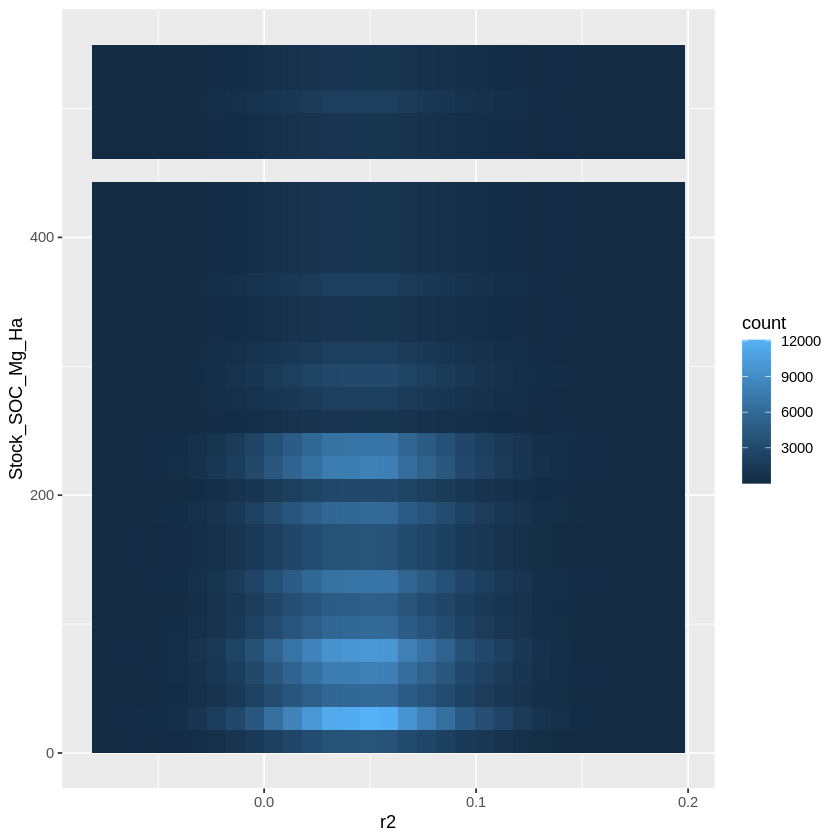

In [57]:
sim_dt %>%
  ggplot(aes(y=Stock_SOC_Mg_Ha,x=r2))+
    geom_bin2d()
    # geom_smooth()